# Import CSV

In [82]:
import pandas as pd
df = pd.read_csv('DSC 288 Processed Reddit Dataset.csv')
print(df)

                                                  Title  \
0     Your anger may be caused by a magnesium defici...   
1     Do you ever get so angry that you wish to kill...   
2     Does anyone else just avoid people because you...   
3     Was anyone else “not allowed” to get upset gro...   
4     I wish people understood that outbursts don't ...   
...                                                 ...   
9073  Fastest way I’ve found to get a panic attack u...   
9074                                 Looking for advice   
9075                        New panic attack experience   
9076  I’m having pretty bad suicidal thoughts, think...   
9077      Anxiety symptoms replicating low blood sugar?   

                                                   Text  Score  Topic  \
0     I tried absolutely everything to fix my chroni...    743  anger   
1     I don't know if it's my anger issues talking o...    692  anger   
2     Lately I’ve been noticing that I take the extr...    489  anger   

# Feature Extraction/Modeling  (Old)

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df['Text_pro'], df['Topic'], test_size=0.2, random_state=2)

In [85]:
#Create Vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [86]:
#Train Classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [87]:
#Make Predictions
y_pred = clf.predict(X_test)

#Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6321585903083701


In [88]:
#Attempt the same but on the title
X_train, X_test, y_train, y_test = train_test_split(df['Title_pro'], df['Topic'], test_size=0.2, random_state=2)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6492290748898678


In [89]:
#Now on combined title and text
X_train, X_test, y_train, y_test = train_test_split(df['T_T_pro'], df['Topic'], test_size=0.2, random_state=2)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6718061674008811


# Visualizations

In [90]:
#Create a confusion matrix
from sklearn.metrics import confusion_matrix

labels = sorted(list(set(y_test)))

cm = confusion_matrix(y_test, y_pred, labels=labels)

In [91]:
#Calculate error rates by dividing the number of misclassified instances in each label
  #by total number of instances of that label
import numpy as np

erates = {}
for i, label in enumerate(labels):
    total_instances = np.sum(cm[i, :])
    errors = np.sum(cm[i, :]) - cm[i, i]
    err = errors / total_instances if total_instances > 0 else 0
    erates[label] = err

In [92]:
#Display
for label, err in erates.items():
        print(f"Error rate for label {label}: {err:.2f}")

Error rate for label anger: 0.91
Error rate for label anxiety: 1.00
Error rate for label bipolar: 0.04
Error rate for label depression: 0.61
Error rate for label eating disorder: 0.05
Error rate for label panic: 0.07


Text(0.5, 1.0, 'Error Rate Predicting each Label in Decimal')

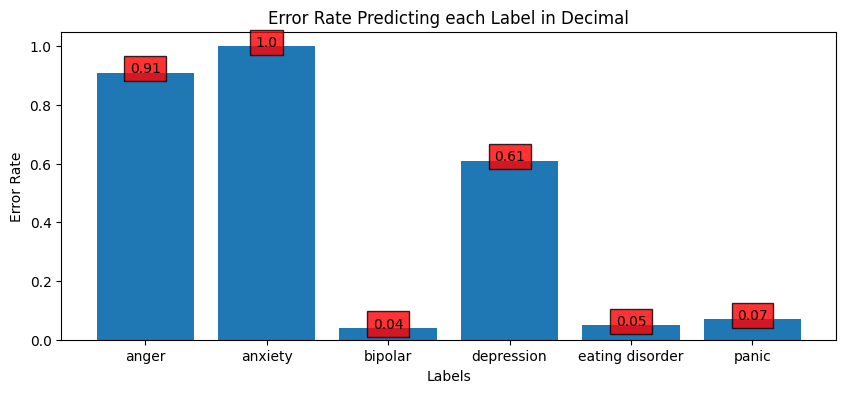

In [93]:
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha='center',
                 bbox = dict(facecolor = 'red', alpha =.8))

labels = list(erates.keys())
errPlain = [round(num, 2) for num in list(erates.values())]

plt.figure(figsize=(10,4))
plt.bar(labels, errPlain)
addlabels(labels, errPlain)
plt.xlabel('Labels')
plt.ylabel('Error Rate')
plt.title('Error Rate Predicting each Label in Decimal')

# Optimization

Tuning alpha value. Higher prevents overfitting but may reduce accuracy. GridSearchCV can find the optimal value.

In [94]:
# Following https://sklearner.com/scikit-learn-grid-search-multinomialnb/
from sklearn.model_selection import GridSearchCV

#define a parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

#Continuing with T_T_pro
grid_search = GridSearchCV(estimator=MultinomialNB(),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

# Report best score and parameters
print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.3f}")

Best score: 0.800
Best parameters: {'alpha': 0.1, 'fit_prior': False}
Test set accuracy: 0.813


In [95]:
#Test again
clf = MultinomialNB(alpha=grid_search.best_params_["alpha"], fit_prior=grid_search.best_params_["fit_prior"])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8127753303964758


Text(0.5, 1.0, 'Error Rate Predicting each Label in Decimal')

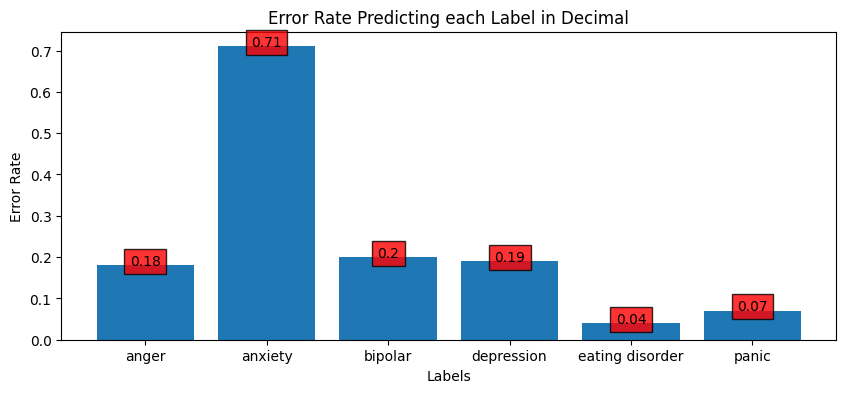

In [96]:
#Visualize
cm = confusion_matrix(y_test, y_pred, labels=labels)

erates = {}
for i, label in enumerate(labels):
    total_instances = np.sum(cm[i, :])
    errors = np.sum(cm[i, :]) - cm[i, i]
    err = errors / total_instances if total_instances > 0 else 0
    erates[label] = err

labels = list(erates.keys())
errOpt = [round(num, 2) for num in list(erates.values())]

plt.figure(figsize=(10,4))
plt.bar(labels, errOpt)
addlabels(labels, errOpt)
plt.xlabel('Labels')
plt.ylabel('Error Rate')
plt.title('Error Rate Predicting each Label in Decimal')

# Remove Common Words

In [97]:
#Remove most common words
df_com = df.copy()
print(df_com['T_T_pro'])

0       anger may caused magnesium deficiency neuron l...
1       ever get angry wish kill moment dont know ange...
2       anyone else avoid people know theyll make angr...
3       anyone else allowed get upset growing always s...
4       wish people understood outburst dont happen sm...
                              ...                        
9073    fastest way ive found get panic attack control...
9074    looking advice hi im f ive professionally diag...
9075    new panic attack experience hi guy wanted see ...
9076    im pretty bad suicidal thought thinking cant h...
9077    anxiety symptom replicating low blood sugar sc...
Name: T_T_pro, Length: 9078, dtype: object


In [98]:
common = ['im', 'like', 'feel', 'dont', 'get' 'time', 'know', 'ive', 'people',
          'day', 'want', 'thing', 'even', 'one', 'life', 'year', 'really', 'make']
for word in common:
  df_com['T_T_pro'] = df_com['T_T_pro'].str.replace(word, '', regex=False)

print(df_com['T_T_pro'])

0       anger may caused magnesium deficiency neuron l...
1       ever get angry wish kill moment   anger issue ...
2       any else avoid   theyll  angry lately  noticin...
3       any else allowed get upset growing always scol...
4       wish  understood outburst  happen small issue ...
                              ...                        
9073    fastest way  found get panic attack control us...
9074    looking advice hi  f  professionally diagnosed...
9075    new panic attack experience hi guy ed see any ...
9076     pretty bad suicidal thought thinking cant han...
9077    anxiety symptom replicating low blood sugar sc...
Name: T_T_pro, Length: 9078, dtype: object


In [99]:
#Model Again
X_train, X_test, y_train, y_test = train_test_split(df_com['T_T_pro'], df_com['Topic'], test_size=0.2, random_state=2)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6718061674008811


In [100]:
#Optimize
grid_search = GridSearchCV(estimator=MultinomialNB(),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.3f}")

Best score: 0.798
Best parameters: {'alpha': 0.1, 'fit_prior': False}
Test set accuracy: 0.814


In [101]:
#Model with optimized parameters
clf = MultinomialNB(alpha=grid_search.best_params_["alpha"], fit_prior=grid_search.best_params_["fit_prior"])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8138766519823789


Text(0.5, 1.0, 'Error Rate Predicting each Label in Decimal')

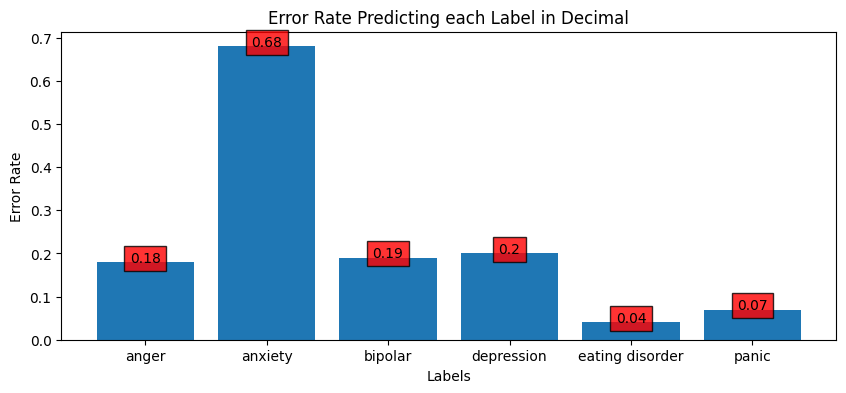

In [102]:
#Visualize
cm = confusion_matrix(y_test, y_pred, labels=labels)

erates = {}
for i, label in enumerate(labels):
    total_instances = np.sum(cm[i, :])
    errors = np.sum(cm[i, :]) - cm[i, i]
    err = errors / total_instances if total_instances > 0 else 0
    erates[label] = err

labels = list(erates.keys())
errCom = [round(num, 2) for num in list(erates.values())]

plt.figure(figsize=(10,4))
plt.bar(labels, errCom)
addlabels(labels, errCom)
plt.xlabel('Labels')
plt.ylabel('Error Rate')
plt.title('Error Rate Predicting each Label in Decimal')

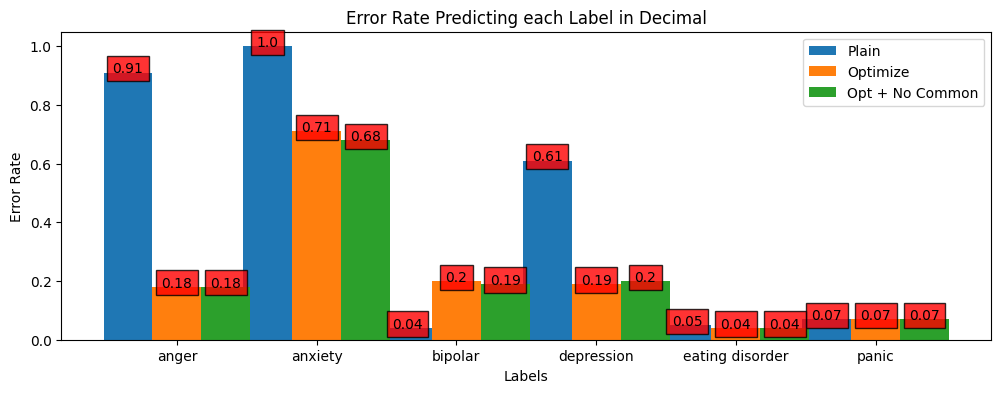

In [103]:
#Display All

def speclabels(x,y):
    for i in range(len(labels)):
        plt.text(i+x,y[i],y[i], ha='center',
                 bbox = dict(facecolor = 'red', alpha =.8))

X = labels
Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]

X_axis = np.arange(len(labels))

plt.figure(figsize=(12,4))
plt.bar(X_axis - 0.35, errPlain, 0.35, label = 'Plain')
plt.bar(X_axis, errOpt, 0.35, label = 'Optimize')
plt.bar(X_axis + 0.35, errCom, 0.35, label = 'Opt + No Common')

plt.xticks(X_axis, X)
speclabels(-0.35, errPlain)
speclabels(0, errOpt)
speclabels(0.35, errCom)
plt.xlabel("Labels")
plt.ylabel('Error Rate')
plt.title('Error Rate Predicting each Label in Decimal')
plt.legend()
plt.show()